In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
from PIL import Image
import requests
import torch
import inspect
import matplotlib.pyplot as plt
from transformers import AutoImageProcessor, AutoModel
processor = AutoImageProcessor.from_pretrained("facebook/dinov2-with-registers-base")
model = AutoModel.from_pretrained("facebook/dinov2-with-registers-base")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
from transformers import Dinov2WithRegistersConfig
config = Dinov2WithRegistersConfig.from_pretrained("facebook/dinov2-with-registers-base")
print(config)

Dinov2WithRegistersConfig {
  "apply_layernorm": true,
  "architectures": [
    "Dinov2WithRegistersModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "drop_path_rate": 0.0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 518,
  "initializer_range": 0.02,
  "interpolate_antialias": true,
  "interpolate_offset": 0.0,
  "layer_norm_eps": 1e-06,
  "layerscale_value": 1.0,
  "mlp_ratio": 4,
  "model_type": "dinov2_with_registers",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "num_register_tokens": 4,
  "out_features": [
    "stage12"
  ],
  "out_indices": [
    12
  ],
  "patch_size": 14,
  "qkv_bias": true,
  "reshape_hidden_states": true,
  "stage_names": [
    "stem",
    "stage1",
    "stage2",
    "stage3",
    "stage4",
    "stage5",
    "stage6",
    "stage7",
    "stage8",
    "stage9",
    "stage10",
    "stage11",
    "stage12"
  ],
  "torch_dtype": "float32",
  "transformers_version": "4.50.3",
  "us

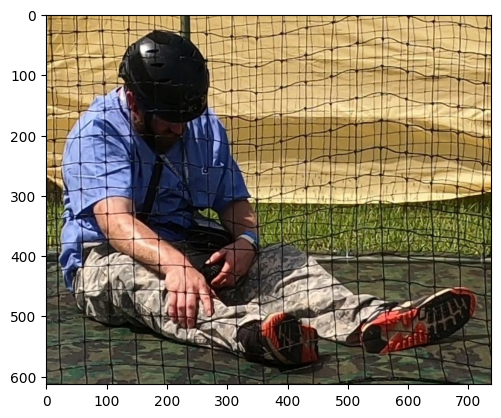

`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


12


In [ ]:
url = "/content/drive/MyDrive/c_data/4.jpg"
image = Image.open(url)
width, height = image.size
plt.imshow(image)
plt.show()
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs, output_attentions = True)
print(len(outputs['attentions']))

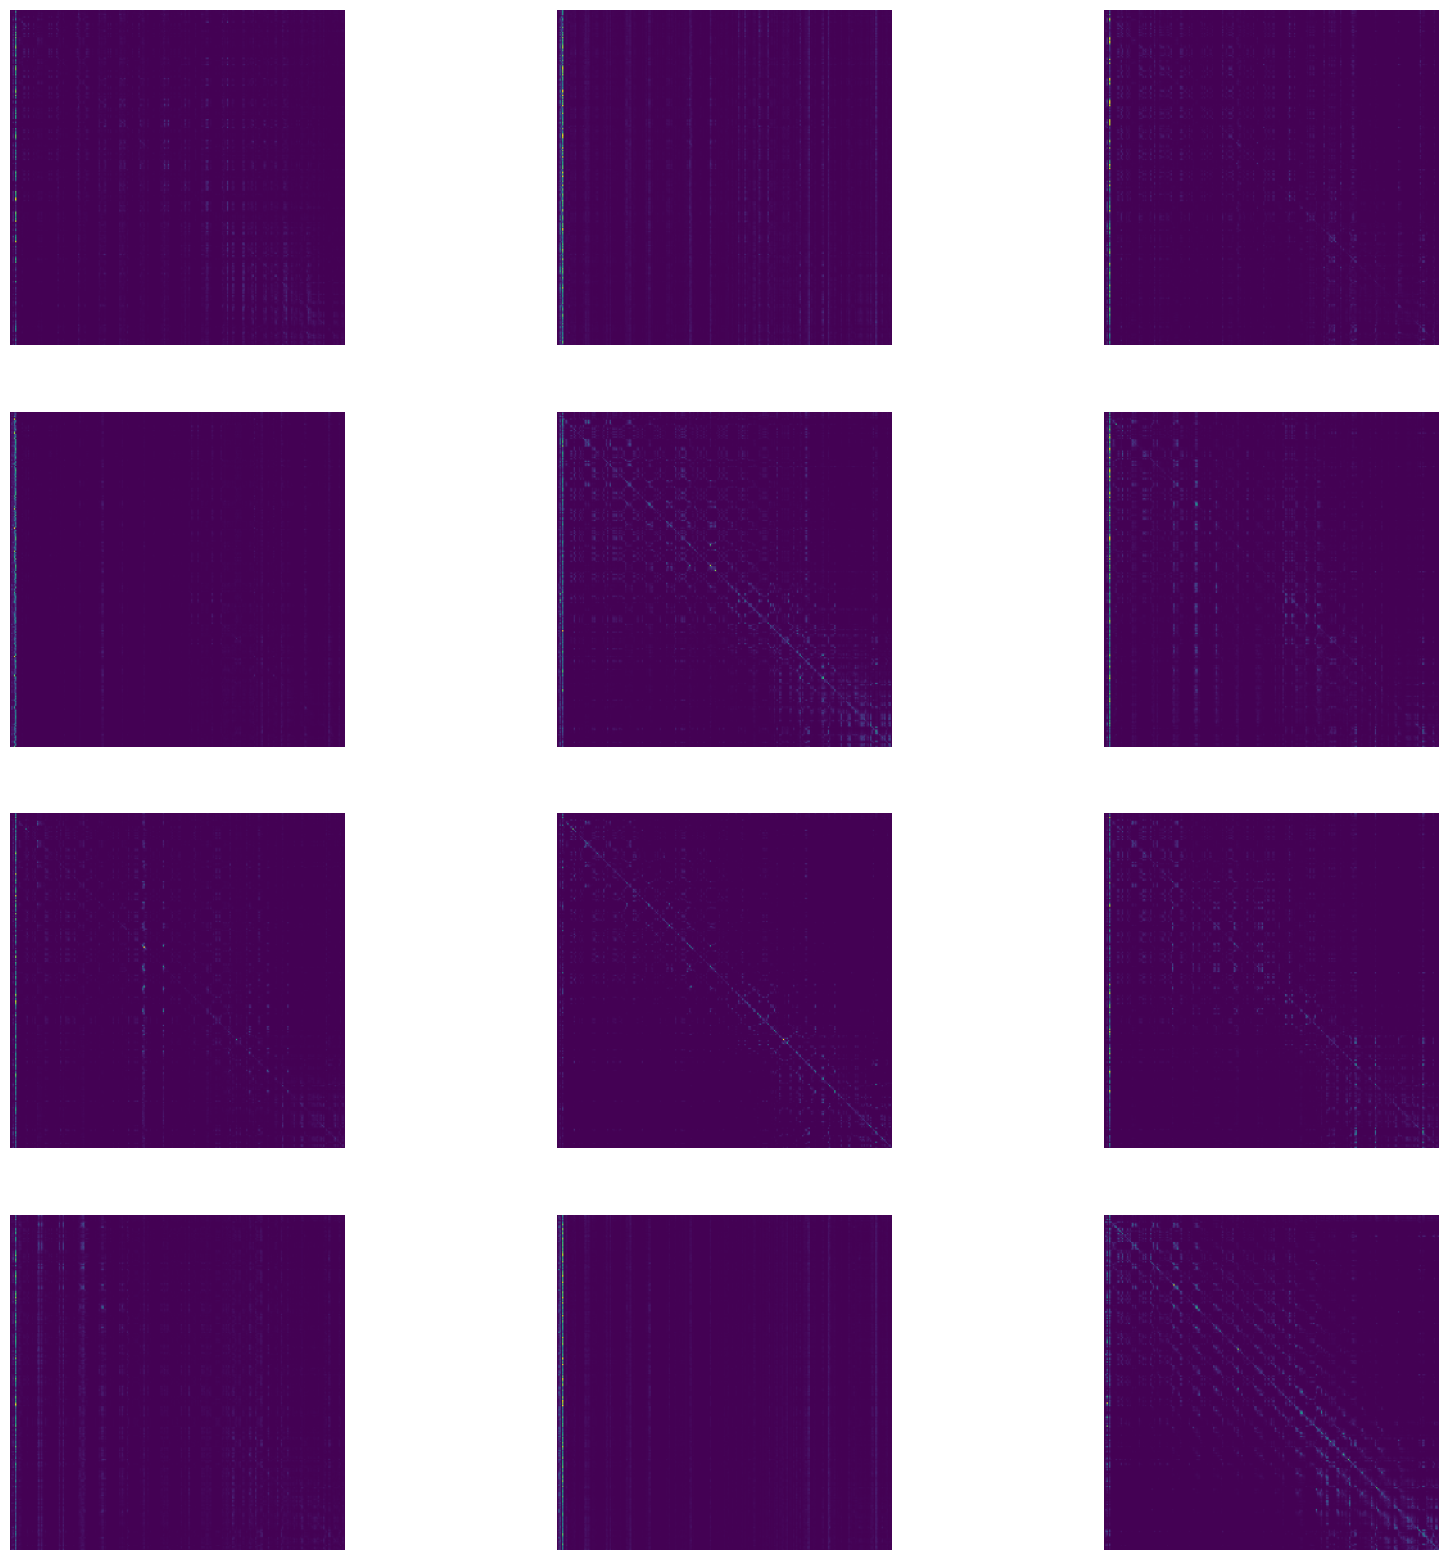

In [ ]:
ig, axs = plt.subplots(4, 3, figsize=(20, 20))
attentions = outputs.attentions
for i, ax in enumerate(axs.flatten()):
  ax.imshow(attentions[-1][0, i, :, :].detach().cpu().numpy())
  ax.axis('off')

In [ ]:
def attention_rollout(attentions):
    # Initialize rollout with identity matrix
    rollout = torch.eye(attentions[0].size(-1)).to(attentions[0].device)


    # Multiply attention maps layer by layer
    for attention in attentions:
        attention_heads_fused = attention.mean(dim=1) # Average attention across heads
        attention_heads_fused += torch.eye(attention_heads_fused.size(-1)).to(attention_heads_fused.device) # A + I
        attention_heads_fused /= attention_heads_fused.sum(dim=-1, keepdim=True) # Normalizing A
        rollout = torch.matmul(rollout, attention_heads_fused) # Multiplication
    return rollout

def visualize_rollout(rollout):
    rollout_attn_map = rollout[0,5:,:].detach().cpu().numpy()
    rollout_attn_map = (rollout_attn_map - rollout_attn_map.min()) / (rollout_attn_map.max() - rollout_attn_map.min())
    rollout_attn_map *= 255
    rollout_attn_map = rollout_attn_map.astype(np.uint8)
    print(np.argmax(rollout_attn_map[0]))
    plt.figure(figsize=(6, 6))
    plt.imshow(rollout_attn_map, cmap='inferno')
    plt.title("Resized & Blurred Attention Map")
    plt.axis('off')
    plt.show()

torch.Size([1, 261, 261])
torch.Size([256])
4


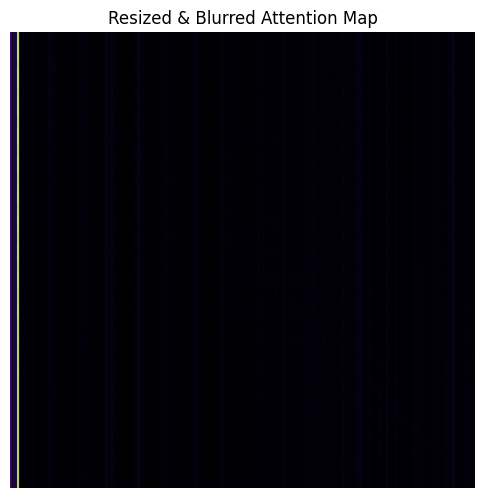

In [ ]:
import numpy as np
from math import gcd

rollout = attention_rollout(attentions)
print(rollout.shape)
cls_attention_c = rollout[0,5:,0]

print(cls_attention_c.shape)  # Get attention values from [CLS] token to all patches

cls_attention_c = 1 - cls_attention_c.reshape(int(np.sqrt(256)), int(np.sqrt(256)))


visualize_rollout(rollout)

In [ ]:
import numpy as np
from PIL import Image, ImageFilter
# Normalize the attention map for better visualization
cls_attention_c = (cls_attention_c - cls_attention_c.min()) / (cls_attention_c.max() - cls_attention_c.min())
# Convert tensor to NumPy
cls_attention_np_c = cls_attention_c.detach().numpy()   # If on GPU, move to CPU first
# Convert to image
cls_attention_resized_c = Image.fromarray((cls_attention_np_c * 255).astype(np.uint8)).resize((width, height), resample=Image.BICUBIC)


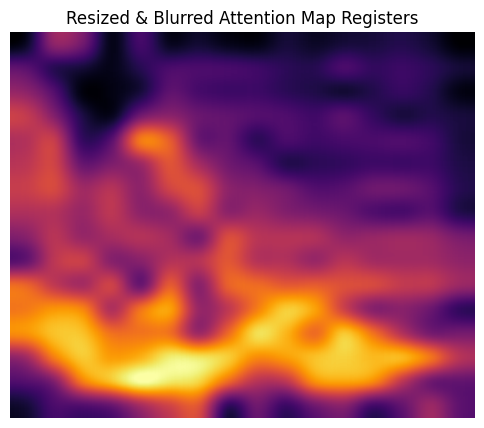

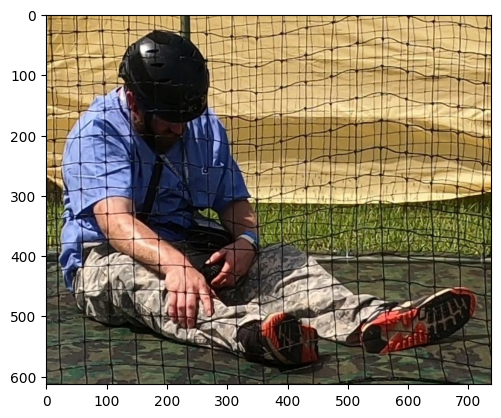

In [ ]:
plt.figure(figsize=(6, 6))
plt.imshow(cls_attention_resized_c, cmap='inferno')
plt.title("Resized & Blurred Attention Map Registers")
plt.axis('off')
plt.show()
plt.imshow(image)